<a href="https://colab.research.google.com/github/sarah-mokhtar/RL-Project-2048/blob/main/2048_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install stable-baselines3[extra] gymnasium numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 17.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces


class Game2048Env(gym.Env):


    metadata = {"render_modes": ["ansi"], "render_fps": 60}

    def __init__(self, render_mode=None, target_tile=2048):
        super().__init__()

        self.board_size = 4
        self.target_tile = target_tile
        self.observation_space = spaces.Box(
            low=0,
            high=15,
            shape=(self.board_size, self.board_size),
            dtype=np.int32,
        )
        self.action_space = spaces.Discrete(4)

        self.render_mode = render_mode
        self.board = np.zeros((self.board_size, self.board_size), dtype=np.int32)
        self.score = 0
        self.rng = np.random.default_rng()

    def _slide_and_merge_line(self, line):
        """
        line: 1D np.array of exponents (0 = empty)
        Returns: (new_line, reward_from_merges)
        """
        non_zero = line[line != 0].tolist()
        new = []
        reward = 0
        i = 0
        while i < len(non_zero):
            if i + 1 < len(non_zero) and non_zero[i] == non_zero[i + 1]:
                exp = non_zero[i] + 1
                new.append(exp)
                reward += 2 ** exp
                i += 2
            else:
                new.append(non_zero[i])
                i += 1
        # pad with zeros
        new += [0] * (len(line) - len(new))
        return np.array(new, dtype=np.int32), reward

    def _add_random_tile(self):
        empty_positions = list(zip(*np.where(self.board == 0)))
        if not empty_positions:
            return
        row, col = empty_positions[self.rng.integers(len(empty_positions))]

        if self.rng.random() < 0.9:
            self.board[row, col] = 1
        else:
            self.board[row, col] = 2

    def _can_move(self):
        # If any cell empty -> can move
        if np.any(self.board == 0):
            return True
        # If any horizontal merge possible
        for i in range(self.board_size):
            for j in range(self.board_size - 1):
                if self.board[i, j] == self.board[i, j + 1]:
                    return True
        # If any vertical merge possible
        for j in range(self.board_size):
            for i in range(self.board_size - 1):
                if self.board[i, j] == self.board[i + 1, j]:
                    return True
        return False

    def _get_max_tile(self):
        exp = int(self.board.max())
        return 0 if exp == 0 else 2 ** exp

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            self.rng = np.random.default_rng(seed)

        self.board[:] = 0
        self.score = 0

        self._add_random_tile()
        self._add_random_tile()

        observation = self.board.copy()
        info = {"score": self.score, "max_tile": self._get_max_tile()}
        return observation, info

    def step(self, action):
        assert self.action_space.contains(action), "Invalid action"

        old_board = self.board.copy()
        reward = 0


        if action == 0:  # up
            for col in range(self.board_size):
                line = self.board[:, col]
                new_line, r = self._slide_and_merge_line(line)
                self.board[:, col] = new_line
                reward += r
        elif action == 1:  # down
            for col in range(self.board_size):
                line = self.board[:, col][::-1]
                new_line, r = self._slide_and_merge_line(line)
                self.board[:, col] = new_line[::-1]
                reward += r
        elif action == 2:  # left
            for row in range(self.board_size):
                line = self.board[row, :]
                new_line, r = self._slide_and_merge_line(line)
                self.board[row, :] = new_line
                reward += r
        elif action == 3:  # right
            for row in range(self.board_size):
                line = self.board[row, :][::-1]
                new_line, r = self._slide_and_merge_line(line)
                self.board[row, :] = new_line[::-1]
                reward += r

        moved = not np.array_equal(old_board, self.board)

        if not moved:
            reward -= 1.0
        else:
            self._add_random_tile()

        self.score += reward

        max_tile = self._get_max_tile()
        terminated = False
        if not self._can_move():
            terminated = True
        if max_tile >= self.target_tile:
            terminated = True

        truncated = False

        observation = self.board.copy()
        info = {"score": self.score, "max_tile": max_tile}

        return observation, reward, terminated, truncated, info

    def render(self):
        if self.render_mode == "ansi":
            return self._board_to_string()
        else:
            print(self._board_to_string())

    def _board_to_string(self):
        display = []
        for row in self.board:
            display_row = []
            for exp in row:
                if exp == 0:
                    display_row.append(".")
                else:
                    display_row.append(str(2 ** int(exp)))
            display.append("\t".join(display_row))
        return "\n".join(display)


In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv

# We already defined Game2048Env above


def make_env():
    def _init():
        env = Game2048Env()
        return env
    return _init


# Create one env to check API
env = Game2048Env()
check_env(env, warn=True)

# Vectorized env for PPO
vec_env = DummyVecEnv([make_env()])

model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=1,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=256,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
)

# 🔁 Training – you can increase timesteps later
model.learn(total_timesteps=2000000)

model.save("ppo_2048")
print("Model saved as ppo_2048.zip")


Streaming output truncated to the last 5000 lines.
|    total_timesteps      | 1433600      |
| train/                  |              |
|    approx_kl            | 0.0018848357 |
|    clip_fraction        | 0.0085       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.546       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 9.44e+03     |
|    n_updates            | 6990         |
|    policy_gradient_loss | -0.00285     |
|    value_loss           | 2.21e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 584          |
|    iterations           | 701          |
|    time_elapsed         | 2457         |
|    total_timesteps      | 1435648      |
| train/                  |              |
|    approx_kl            | 0.0014606611 |
|    clip_fraction        | 0.00464      |
|  

In [ ]:
import time
from stable_baselines3 import PPO

# Load model
model = PPO.load("ppo_2048")

env = Game2048Env(render_mode="ansi")

obs, info = env.reset()
done = False
step = 0

print("Initial board:")
print(env._board_to_string())

while not done:
    # stochastic actions so you can see exploration / variability
    action, _ = model.predict(obs, deterministic=False)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    print(f"\nStep {step}, action={action}, reward={reward}, score={info['score']}")
    print(env._board_to_string())
    time.sleep(0.1)
    step += 1

print("\nEpisode finished.")
print(f"Final score: {info['score']}, max tile: {info['max_tile']}")


Initial board:
.	.	.	.
2	.	.	2
.	.	.	.
.	.	.	.

Step 0, action=0, reward=0, score=0
2	2	.	2
.	.	.	.
.	.	.	.
.	.	.	.

Step 1, action=3, reward=4, score=4
.	.	2	4
.	.	.	.
.	.	2	.
.	.	.	.

Step 2, action=1, reward=4, score=8
.	.	.	.
.	.	.	.
.	2	.	.
.	.	4	4

Step 3, action=0, reward=0, score=8
.	2	4	4
.	.	.	.
.	2	.	.
.	.	.	.

Step 4, action=3, reward=8, score=16
.	.	2	8
.	.	.	.
2	.	.	2
.	.	.	.

Step 5, action=3, reward=4, score=20
.	.	2	8
2	.	.	.
.	.	.	4
.	.	.	.

Step 6, action=1, reward=0, score=20
4	.	.	.
.	.	.	.
.	.	.	8
2	.	2	4

Step 7, action=0, reward=0, score=20
4	.	2	8
2	.	.	4
.	.	.	.
2	.	.	.

Step 8, action=1, reward=4, score=24
.	.	.	.
.	.	.	2
4	.	.	8
4	.	2	4

Step 9, action=2, reward=0, score=24
.	.	.	.
2	2	.	.
4	8	.	.
4	2	4	.

Step 10, action=0, reward=8, score=32
2	2	4	.
8	8	.	.
.	2	.	2
.	.	.	.

Step 11, action=3, reward=24, score=56
.	.	4	4
.	.	.	16
.	.	.	4
2	.	.	.

Step 12, action=1, reward=0, score=56
.	.	.	.
.	.	.	4
.	.	2	16
2	.	4	4

Step 13, action=2, reward=8, score=64
2	

In [ ]:
!git config --global user.email "sarah04@mit.edu"
!git config --global user.name "sarah-mokhtar"


In [ ]:
!git clone https://github.com/sarah-mokhtar/RL-Project-2048.git



fatal: destination path 'RL-Project-2048' already exists and is not an empty directory.


In [ ]:

!cp 2048\ RL.ipynb /content/RL-Project-2048/




cp: cannot stat '2048 RL.ipynb': No such file or directory


In [ ]:
%cd RL-Project-2048

!git add .
!git commit -m "PPO"
!git push


[Errno 2] No such file or directory: 'RL-Project-2048'
/content/RL-Project-2048
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
# Clone a team/organization repo

from getpass import getpass

# Get your Personal Access Token
print("Get token from: https://github.com/settings/tokens")
print("Make sure 'repo' scope is checked!")
token = getpass('Paste your GitHub Personal Access Token: ')

# Team/Organization repo details
org_or_username = "team-name-or-org"  # The organization/team name
repo_name = "repo-name"  # The repository name

# Clone with authentication
!git clone https://{token}@github.com/{org_or_username}/{repo_name}.git

# Navigate into repo
%cd {repo_name}

# Configure your git identity (important for team repos)
!git config user.email "your-email@example.com"
!git config user.name "Your Name"

print("✅ Team repo cloned successfully!")

In [ ]:
!git clone https://github.com/Ali-Backour/2048_RL.git

Cloning into '2048_RL'...
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces


class Game2048EnvV2(gym.Env):
    """
    Version 2 of the 2048 environment.
    Same logic as V1, but you can modify reward shaping etc. later.

    Normalized observation: exponents / 15.0 → float32 in [0,1]
    """

    metadata = {"render_modes": ["ansi"], "render_fps": 60}

    def __init__(self, render_mode=None, target_tile=2048):
        super().__init__()
        self.board_size = 4
        self.target_tile = target_tile

        self.observation_space = spaces.Box(
            low=0.0,
            high=1.0,
            shape=(4, 4),
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(4)

        self.render_mode = render_mode
        self.board = np.zeros((4, 4), dtype=np.int32)
        self.score = 0.0
        self.prev_max_tile = 0
        self.rng = np.random.default_rng()

    # ---------- Helpers ----------
    def _get_obs(self):
        return self.board.astype(np.float32) / 15.0

    def _slide_and_merge_line(self, line):
        non_zero = line[line != 0].tolist()
        new = []
        reward = 0
        i = 0
        while i < len(non_zero):
            if i+1 < len(non_zero) and non_zero[i] == non_zero[i+1]:
                exp = non_zero[i] + 1
                new.append(exp)
                reward += 2**exp
                i += 2
            else:
                new.append(non_zero[i])
                i += 1
        new += [0]*(len(line)-len(new))
        return np.array(new, dtype=np.int32), reward

    def _add_random_tile(self):
        empty = list(zip(*np.where(self.board == 0)))
        if not empty:
            return
        r, c = empty[self.rng.integers(len(empty))]
        self.board[r,c] = 1 if self.rng.random()<0.9 else 2

    def _can_move(self):
        if np.any(self.board==0): return True
        for r in range(4):
            for c in range(3):
                if self.board[r,c]==self.board[r,c+1]:
                    return True
        for c in range(4):
            for r in range(3):
                if self.board[r,c]==self.board[r+1,c]:
                    return True
        return False

    def _get_max_tile(self):
        return 0 if self.board.max()==0 else 2**int(self.board.max())

    # ---------- Gym API ----------
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            self.rng = np.random.default_rng(seed)

        self.board[:] = 0
        self.score = 0.0
        self.prev_max_tile = 0

        self._add_random_tile()
        self._add_random_tile()

        return self._get_obs(), {"score":0, "max_tile":self._get_max_tile()}

    def step(self, action):
        old_board = self.board.copy()
        reward = 0

        if action == 0:
            for c in range(4):
                new_line, r = self._slide_and_merge_line(self.board[:,c])
                self.board[:,c] = new_line
                reward += r
        elif action == 1:
            for c in range(4):
                new_line, r = self._slide_and_merge_line(self.board[:,c][::-1])
                self.board[:,c] = new_line[::-1]
                reward += r
        elif action == 2:
            for r in range(4):
                new_line, rwd = self._slide_and_merge_line(self.board[r])
                self.board[r] = new_line
                reward += rwd
        elif action == 3:
            for r in range(4):
                new_line, rwd = self._slide_and_merge_line(self.board[r][::-1])
                self.board[r] = new_line[::-1]
                reward += rwd

        moved = not np.array_equal(old_board, self.board)

        if not moved:
            reward -= 2.0
        else:
            self._add_random_tile()

        max_tile = self._get_max_tile()

        # reward shaping
        if max_tile > self.prev_max_tile:
            reward += 0.5
        self.prev_max_tile = max_tile

        reward += 0.01 * np.sum(self.board==0)
        self.score += reward

        terminated = (not self._can_move()) or (max_tile >= self.target_tile)
        truncated = False

        return self._get_obs(), reward, terminated, truncated, {
            "score": self.score,
            "max_tile": max_tile
        }

    def _board_to_string(self):
        rows = []
        for row in self.board:
            r = []
            for exp in row:
                r.append("." if exp==0 else str(2**exp))
            rows.append("\t".join(r))
        return "\n".join(rows)


In [ ]:
from stable_baselines3 import PPO

env_v2 = Game2048EnvV2()

policy_kwargs_v2 = dict(
    net_arch=[dict(pi=[256, 256, 256],
                   vf=[256, 256, 256])]
)

model_v2 = PPO(
    "MlpPolicy",
    env_v2,
    policy_kwargs=policy_kwargs_v2,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=512,
    n_epochs=10,
    gamma=0.99,
    clip_range=0.15,
    ent_coef=0.05,      # 🔼 higher entropy → more stochastic policy
    target_kl=0.02,
    verbose=1,
)

model_v2.learn(total_timesteps=300_000)

model_v2.save("ppo_2048_v2_simple")
print("Saved model ppo_2048_v2_simple.zip")


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 149      |
|    ep_rew_mean     | 1.16e+03 |
| time/              |          |
|    fps             | 608      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 147           |
|    ep_rew_mean          | 1.13e+03      |
| time/                   |               |
|    fps                  | 592           |
|    iterations           | 2             |
|    time_elapsed         | 6             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00044112414 |
|    clip_fraction        | 0             |
|    clip_range           | 0.15          |
|    entropy_loss         | -1.39         |
|    explained_variance   | -5.89e-05     |


In [ ]:
import time
from stable_baselines3 import PPO

model_v2 = PPO.load("ppo_2048_v2_simple")

env_eval = Game2048EnvV2(render_mode="ansi")
obs, info = env_eval.reset()
done = False
step = 0

print("Initial board:")
print(env_eval._board_to_string())

while not done:
    # 🔽 IMPORTANT: try deterministic=False to see variety
    action, _ = model_v2.predict(obs, deterministic=False)
    obs, reward, terminated, truncated, info = env_eval.step(int(action))
    done = terminated or truncated

    print(f"\nStep {step}, action={int(action)}, reward={reward:.2f}, score={info['score']:.2f}")
    print(env_eval._board_to_string())
    time.sleep(0.1)
    step += 1

print("\nEpisode finished.")
print(f"Final score: {info['score']}, max tile: {info['max_tile']}")


Initial board:
.	.	.	4
.	.	.	.
.	.	2	.
.	.	.	.

Step 0, action=1, reward=0.63, score=0.63
.	.	.	2
.	.	.	.
.	.	.	.
.	.	2	4

Step 1, action=2, reward=0.12, score=0.75
2	.	2	.
.	.	.	.
.	.	.	.
2	4	.	.

Step 2, action=0, reward=4.12, score=4.87
4	4	2	.
.	.	.	.
.	.	.	.
.	.	4	.

Step 3, action=0, reward=0.11, score=4.98
4	4	2	.
.	.	4	.
.	.	.	.
.	.	.	2

Step 4, action=1, reward=0.10, score=5.08
.	.	.	.
.	.	.	2
.	.	2	.
4	4	4	2

Step 5, action=0, reward=4.10, score=9.18
4	4	2	4
.	.	4	.
2	.	.	.
.	.	.	.

Step 6, action=3, reward=8.60, score=17.78
.	8	2	4
.	.	2	4
.	.	.	2
.	.	.	.

Step 7, action=2, reward=0.09, score=17.87
8	2	4	.
2	4	.	.
2	.	.	2
.	.	.	.

Step 8, action=0, reward=4.09, score=21.96
8	2	4	2
4	4	.	.
.	.	.	.
.	.	2	.

Step 9, action=1, reward=0.08, score=22.04
.	.	2	.
.	.	.	.
8	2	4	.
4	4	2	2

Step 10, action=3, reward=12.09, score=34.13
.	.	.	2
2	.	.	.
.	8	2	4
.	.	8	4

Step 11, action=0, reward=8.09, score=42.22
2	8	2	2
.	2	8	8
.	.	.	.
.	.	.	.

Step 12, action=1, reward=0.08, score=42.30

In [ ]:
import numpy as np
from stable_baselines3 import PPO

# ---- Settings ----
NUM_EPISODES = 30
MODEL_PATH = "ppo_2048_v2_simple"  # change if your model name is different

# ---- Helper: run one episode with a given policy ----
def run_episode_with_policy(env, policy_fn, render=False):
    obs, info = env.reset()
    done = False
    total_reward = 0.0
    final_score = 0.0
    max_tile = 0

    while not done:
        action = policy_fn(obs, env)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        total_reward += reward
        final_score = info["score"]
        max_tile = info["max_tile"]

        if render:
            print(env._board_to_string())
            print(f"Action: {action}, Reward: {reward:.2f}, Score: {final_score:.2f}")
            print("-" * 40)

    return total_reward, final_score, max_tile

# ---- Random policy ----
def random_policy(obs, env):
    return env.action_space.sample()

# ---- PPO policy ----
print("Loading PPO model...")
ppo_model = PPO.load(MODEL_PATH)

def ppo_policy(obs, env):
    action, _ = ppo_model.predict(obs, deterministic=True)
    return int(action)

# ---- Evaluate both ----
def evaluate_policy(name, policy_fn, num_episodes=NUM_EPISODES, render=False):
    rewards = []
    scores = []
    max_tiles = []

    for ep in range(num_episodes):
        env = Game2048EnvV2()  # new fresh env each episode
        total_r, score, max_tile = run_episode_with_policy(env, policy_fn, render=False)
        rewards.append(total_r)
        scores.append(score)
        max_tiles.append(max_tile)

    print(f"\n=== {name} over {num_episodes} episodes ===")
    print(f"Avg total reward: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
    print(f"Avg final score:  {np.mean(scores):.2f} ± {np.std(scores):.2f}")
    print(f"Avg max tile:     {np.mean(max_tiles):.1f}")
    print(f"Max of max tiles: {np.max(max_tiles)}")

    return rewards, scores, max_tiles

# Run comparison
rand_rewards, rand_scores, rand_tiles = evaluate_policy("Random policy", random_policy)
ppo_rewards,  ppo_scores,  ppo_tiles  = evaluate_policy("PPO policy",    ppo_policy)

print("\nDone.")


Loading PPO model...

=== Random policy over 30 episodes ===
Avg total reward: 991.10 ± 475.12
Avg final score:  991.10 ± 475.12
Avg max tile:     104.5
Max of max tiles: 256


KeyboardInterrupt: 

In [2]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class Game2048EnvV3(gym.Env):
    """
    Simple, stable 2048 env for PPO.

    - Obs: 4x4 grid, exponents / 15.0 in [0, 1]
    - Action: 0=up,1=down,2=left,3=right
    - Reward:
        * (sum of merged tile values) / 32.0
        * -1 for invalid move (no board change)
    """

    metadata = {"render_modes": ["ansi"], "render_fps": 60}

    def __init__(self, render_mode=None, target_tile=2048):
        super().__init__()
        self.board_size = 4
        self.target_tile = target_tile

        self.observation_space = spaces.Box(
            low=0.0,
            high=1.0,
            shape=(self.board_size, self.board_size),
            dtype=np.float32,
        )
        self.action_space = spaces.Discrete(4)

        self.render_mode = render_mode
        self.board = np.zeros((self.board_size, self.board_size), dtype=np.int32)
        self.score = 0.0
        self.rng = np.random.default_rng()

    # ---------- Helpers ----------
    def _get_obs(self):
        return self.board.astype(np.float32) / 15.0

    def _slide_and_merge_line(self, line):
        non_zero = line[line != 0].tolist()
        new = []
        merged_value = 0
        i = 0
        while i < len(non_zero):
            if i + 1 < len(non_zero) and non_zero[i] == non_zero[i+1]:
                exp = non_zero[i] + 1
                new.append(exp)
                merged_value += 2 ** exp
                i += 2
            else:
                new.append(non_zero[i])
                i += 1
        new += [0] * (len(line) - len(new))
        return np.array(new, dtype=np.int32), merged_value

    def _add_random_tile(self):
        empties = list(zip(*np.where(self.board == 0)))
        if not empties:
            return
        r, c = empties[self.rng.integers(len(empties))]
        self.board[r, c] = 1 if self.rng.random() < 0.9 else 2  # 2 or 4

    def _can_move(self):
        if np.any(self.board == 0):
            return True
        for r in range(self.board_size):
            for c in range(self.board_size - 1):
                if self.board[r, c] == self.board[r, c+1]:
                    return True
        for c in range(self.board_size):
            for r in range(self.board_size - 1):
                if self.board[r, c] == self.board[r+1, c]:
                    return True
        return False

    def _get_max_tile(self):
        exp = int(self.board.max())
        return 0 if exp == 0 else 2 ** exp

    # ---------- Gym API ----------
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            self.rng = np.random.default_rng(seed)

        self.board[:] = 0
        self.score = 0.0

        self._add_random_tile()
        self._add_random_tile()

        return self._get_obs(), {"score": self.score, "max_tile": self._get_max_tile()}

    def step(self, action):
        assert self.action_space.contains(action), "Invalid action"

        old_board = self.board.copy()
        merged_value = 0

        if action == 0:  # up
            for c in range(self.board_size):
                new_line, mv = self._slide_and_merge_line(self.board[:, c])
                self.board[:, c] = new_line
                merged_value += mv
        elif action == 1:  # down
            for c in range(self.board_size):
                new_line, mv = self._slide_and_merge_line(self.board[:, c][::-1])
                self.board[:, c] = new_line[::-1]
                merged_value += mv
        elif action == 2:  # left
            for r in range(self.board_size):
                new_line, mv = self._slide_and_merge_line(self.board[r])
                self.board[r] = new_line
                merged_value += mv
        elif action == 3:  # right
            for r in range(self.board_size):
                new_line, mv = self._slide_and_merge_line(self.board[r][::-1])
                self.board[r] = new_line[::-1]
                merged_value += mv

        moved = not np.array_equal(old_board, self.board)

        reward = 0.0
        if moved:
            self._add_random_tile()
            # scale down raw 2048 reward to keep PPO stable
            reward += merged_value / 32.0
        else:
            # strong penalty for useless move
            reward -= 1.0

        self.score += merged_value  # human-style score for reporting

        max_tile = self._get_max_tile()
        terminated = (not self._can_move()) or (max_tile >= self.target_tile)
        truncated = False

        obs = self._get_obs()
        info = {"score": self.score, "max_tile": max_tile}
        return obs, reward, terminated, truncated, info

    def _board_to_string(self):
        rows = []
        for row in self.board:
            r = []
            for exp in row:
                r.append("." if exp == 0 else str(2 ** exp))
            rows.append("\t".join(r))
        return "\n".join(rows)


In [3]:
from stable_baselines3 import PPO

env = Game2048EnvV3()

policy_kwargs = dict(
    net_arch=[dict(pi=[256, 256, 256],
                   vf=[256, 256, 256])]
)

model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs=policy_kwargs,
    learning_rate=1e-4,   # smaller LR
    n_steps=4096,         # more rollout per update
    batch_size=512,
    n_epochs=20,          # reuse data more
    gamma=0.99,
    clip_range=0.1,
    ent_coef=0.1,         # stronger exploration
    target_kl=0.02,
    verbose=1,
)

model.learn(total_timesteps=2_000_000)  # 2M instead of 500k
model.save("ppo_2048_v3_big")


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetim

Streaming output truncated to the last 5000 lines.
|    value_loss           | 8.07         |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 121          |
|    ep_rew_mean          | 18.5         |
| time/                   |              |
|    fps                  | 553          |
|    iterations           | 252          |
|    time_elapsed         | 1865         |
|    total_timesteps      | 1032192      |
| train/                  |              |
|    approx_kl            | 0.0016753317 |
|    clip_fraction        | 0.0377       |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.3         |
|    explained_variance   | 0.461        |
|    learning_rate        | 0.0001       |
|    loss                 | 3.19         |
|    n_updates            | 5020         |
|    policy_gradient_loss | -0.00353     |
|    value_loss           | 7.36         |
---

In [ ]:
import torch
from stable_baselines3.common.preprocessing import preprocess_obs

env_dbg = Game2048EnvV3()
obs, info = env_dbg.reset()

for i in range(5):
    obs_tensor = torch.as_tensor([obs], device=model.device)
    obs_tensor = preprocess_obs(obs_tensor, env_dbg.observation_space)

    dist = model.policy.get_distribution(obs_tensor)
    probs = dist.distribution.probs.detach().cpu().numpy()[0]

    print(f"Probs on state {i}: {probs}")

    # create new state
    action = env_dbg.action_space.sample()
    obs, _, done, _, _ = env_dbg.step(action)
    if done:
        obs, info = env_dbg.reset()


Probs on state 0: [0.26067576 0.22560897 0.22320904 0.29050624]
Probs on state 1: [0.18664004 0.33731905 0.13716367 0.33887723]
Probs on state 2: [0.14637853 0.40725422 0.15866132 0.2877059 ]
Probs on state 3: [0.11983611 0.4621226  0.31354755 0.10449384]
Probs on state 4: [0.10891565 0.47009867 0.3245981  0.09638763]


/tmp/ipython-input-2830357457.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  obs_tensor = torch.as_tensor([obs], device=model.device)


In [ ]:
env = Game2048EnvV3()
obs, info = env.reset()

print("Initial obs:", obs.flatten())

for i in range(5):
    action = env.action_space.sample()
    obs, reward, term, trunc, info = env.step(action)
    print(f"Step {i}, action={action}, obs:", obs.flatten())


Initial obs: [0.06666667 0.         0.         0.         0.         0.
 0.         0.         0.06666667 0.         0.         0.
 0.         0.         0.         0.        ]
Step 0, action=2, obs: [0.06666667 0.         0.         0.         0.         0.
 0.         0.         0.06666667 0.         0.         0.
 0.         0.         0.         0.        ]
Step 1, action=1, obs: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.06666667
 0.13333334 0.         0.         0.        ]
Step 2, action=0, obs: [0.13333334 0.06666667 0.         0.06666667 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
Step 3, action=2, obs: [0.13333334 0.13333334 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.06666667 0.         0.         0.        ]
Step 4, action=0, obs: [0.13333334 0.13333334 0.         0.        

In [6]:
import time
from stable_baselines3 import PPO

# Load the trained model
model = PPO.load("ppo_2048_v3_big")

# Create a fresh environment for playing
env = Game2048EnvV3(render_mode="ansi")

obs, info = env.reset()
done = False
step = 0

print("Initial Board:")
print(env._board_to_string())

while not done:
    # deterministic=True = best move according to PPO
    # deterministic=False = allows exploration
    action, _ = model.predict(obs, deterministic=False)

    obs, reward, terminated, truncated, info = env.step(int(action))
    done = terminated or truncated

    print(f"\nStep {step} | Action: {int(action)} | Reward: {reward:.2f} | Score: {info['score']:.1f}")
    print(env._board_to_string())
    print("-" * 40)

    step += 1
    time.sleep(0.15)  # Slow down for visual effect (optional)

print("\n=== Episode Finished ===")
print(f"Final Score: {info['score']}")
print(f"Max Tile: {info['max_tile']}")


Initial Board:
.	.	.	.
.	2	.	.
.	.	2	.
.	.	.	.

Step 0 | Action: 0 | Reward: 0.00 | Score: 0.0
.	2	2	.
.	.	4	.
.	.	.	.
.	.	.	.
----------------------------------------

Step 1 | Action: 1 | Reward: 0.00 | Score: 0.0
.	.	.	.
.	.	.	.
.	2	2	.
.	2	4	.
----------------------------------------

Step 2 | Action: 1 | Reward: 0.12 | Score: 4.0
.	.	.	.
.	.	.	.
.	.	2	2
.	4	4	.
----------------------------------------

Step 3 | Action: 1 | Reward: 0.00 | Score: 4.0
.	.	.	2
.	.	.	.
.	.	2	.
.	4	4	2
----------------------------------------

Step 4 | Action: 0 | Reward: 0.12 | Score: 8.0
.	4	2	4
.	.	4	.
.	.	.	.
.	2	.	.
----------------------------------------

Step 5 | Action: 0 | Reward: 0.00 | Score: 8.0
.	4	2	4
.	2	4	4
.	.	.	.
.	.	.	.
----------------------------------------

Step 6 | Action: 2 | Reward: 0.25 | Score: 16.0
4	2	4	.
2	8	.	.
.	.	.	.
.	.	.	2
----------------------------------------

Step 7 | Action: 1 | Reward: 0.00 | Score: 16.0
.	.	.	.
.	.	.	.
4	2	.	2
2	8	4	2
------------------------

In [7]:
import numpy as np
from stable_baselines3 import PPO

NUM_EPISODES = 30

# Load model
ppo_model = PPO.load("ppo_2048_v3_big")

def run_episode(env, policy_fn):
    obs, info = env.reset()
    done = False
    total_reward = 0.0
    final_score = 0.0
    max_tile = 0

    while not done:
        action = policy_fn(obs, env)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        total_reward += reward
        final_score = info["score"]
        max_tile = info["max_tile"]

    return total_reward, final_score, max_tile

def random_policy(obs, env):
    return env.action_space.sample()

def ppo_policy(obs, env):
    action, _ = ppo_model.predict(obs, deterministic=True)
    return int(action)

def evaluate(name, policy_fn, num_episodes=NUM_EPISODES):
    rewards, scores, tiles = [], [], []
    for _ in range(num_episodes):
        env = Game2048EnvV3()
        R, S, T = run_episode(env, policy_fn)
        rewards.append(R)
        scores.append(S)
        tiles.append(T)
    print(f"\n=== {name} over {num_episodes} episodes ===")
    print(f"Avg total_reward: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
    print(f"Avg final score:  {np.mean(scores):.2f} ± {np.std(scores):.2f}")
    print(f"Avg max tile:     {np.mean(tiles):.1f}")
    print(f"Max of max tiles: {np.max(tiles)}")
    return rewards, scores, tiles

rand_r, rand_s, rand_t = evaluate("Random", random_policy)
ppo_r,  ppo_s,  ppo_t  = evaluate("PPO",    ppo_policy,num_episodes=2)

print("\nDone.")



=== Random over 30 episodes ===
Avg total_reward: 9.68 ± 10.65
Avg final score:  962.40 ± 466.98
Avg max tile:     89.6
Max of max tiles: 128


KeyboardInterrupt: 

In [2]:
!pip install gymnasium stable-baselines3 sb3-contrib numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 8.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class Game2048EnvV4(gym.Env):
    """
    2048 with action masking support.

    - Obs: 4x4 grid, exponents / 15.0 in [0, 1]
    - Action: 0=up,1=down,2=left,3=right
    - Reward:
        * (sum of merged tile values) / 32.0
        * -1 for invalid move (but with masking we should never see those)
    - get_action_mask(): True where action is valid (changes board)
    """

    metadata = {"render_modes": ["ansi"], "render_fps": 60}

    def __init__(self, render_mode=None, target_tile=2048):
        super().__init__()
        self.board_size = 4
        self.target_tile = target_tile

        self.observation_space = spaces.Box(
            low=0.0,
            high=1.0,
            shape=(self.board_size, self.board_size),
            dtype=np.float32,
        )
        self.action_space = spaces.Discrete(4)

        self.render_mode = render_mode
        self.board = np.zeros((self.board_size, self.board_size), dtype=np.int32)
        self.score = 0.0
        self.rng = np.random.default_rng()

    # ---------- Helpers ----------
    def _get_obs(self):
        return self.board.astype(np.float32) / 15.0

    def _slide_and_merge_line(self, line):
        non_zero = line[line != 0].tolist()
        new = []
        merged_value = 0
        i = 0
        while i < len(non_zero):
            if i + 1 < len(non_zero) and non_zero[i] == non_zero[i+1]:
                exp = non_zero[i] + 1
                new.append(exp)
                merged_value += 2 ** exp
                i += 2
            else:
                new.append(non_zero[i])
                i += 1
        new += [0] * (len(line) - len(new))
        return np.array(new, dtype=np.int32), merged_value

    def _add_random_tile(self):
        empties = list(zip(*np.where(self.board == 0)))
        if not empties:
            return
        r, c = empties[self.rng.integers(len(empties))]
        self.board[r, c] = 1 if self.rng.random() < 0.9 else 2  # 2 or 4

    def _can_move(self):
        if np.any(self.board == 0):
            return True
        for r in range(self.board_size):
            for c in range(self.board_size - 1):
                if self.board[r, c] == self.board[r, c+1]:
                    return True
        for c in range(self.board_size):
            for r in range(self.board_size - 1):
                if self.board[r, c] == self.board[r+1, c]:
                    return True
        return False

    def _get_max_tile(self):
        exp = int(self.board.max())
        return 0 if exp == 0 else 2 ** exp

    # ---------- Simulation for masking ----------
    def _simulate_move(self, action):
        """
        Return the board that would result from taking `action`,
        without changing the real env state and without adding a random tile.
        """
        board = self.board
        result = board.copy()

        if action == 0:  # up
            for c in range(self.board_size):
                new_line, _ = self._slide_and_merge_line(board[:, c])
                result[:, c] = new_line
        elif action == 1:  # down
            for c in range(self.board_size):
                new_line, _ = self._slide_and_merge_line(board[:, c][::-1])
                result[:, c] = new_line[::-1]
        elif action == 2:  # left
            for r in range(self.board_size):
                new_line, _ = self._slide_and_merge_line(board[r])
                result[r] = new_line
        elif action == 3:  # right
            for r in range(self.board_size):
                new_line, _ = self._slide_and_merge_line(board[r][::-1])
                result[r] = new_line[::-1]

        return result

    def get_action_mask(self):
        """
        Returns a boolean mask of shape (4,):
        True = action changes the board, False = action would do nothing.
        """
        mask = np.zeros(self.action_space.n, dtype=bool)
        for a in range(self.action_space.n):
            new_board = self._simulate_move(a)
            mask[a] = not np.array_equal(self.board, new_board)

        # Safety: if somehow no action changes the board, allow all (should only happen at terminal).
        if not mask.any():
            mask[:] = True
        return mask

    # ---------- Gym API ----------
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            self.rng = np.random.default_rng(seed)

        self.board[:] = 0
        self.score = 0.0

        self._add_random_tile()
        self._add_random_tile()

        return self._get_obs(), {"score": self.score, "max_tile": self._get_max_tile()}

    def step(self, action):
        assert self.action_space.contains(action), "Invalid action"

        old_board = self.board.copy()
        merged_value = 0

        if action == 0:  # up
            for c in range(self.board_size):
                new_line, mv = self._slide_and_merge_line(self.board[:, c])
                self.board[:, c] = new_line
                merged_value += mv
        elif action == 1:  # down
            for c in range(self.board_size):
                new_line, mv = self._slide_and_merge_line(self.board[:, c][::-1])
                self.board[:, c] = new_line[::-1]
                merged_value += mv
        elif action == 2:  # left
            for r in range(self.board_size):
                new_line, mv = self._slide_and_merge_line(self.board[r])
                self.board[r] = new_line
                merged_value += mv
        elif action == 3:  # right
            for r in range(self.board_size):
                new_line, mv = self._slide_and_merge_line(self.board[r][::-1])
                self.board[r] = new_line[::-1]
                merged_value += mv

        moved = not np.array_equal(old_board, self.board)

        reward = 0.0
        if moved:
            self._add_random_tile()
            reward += merged_value / 32.0
        else:
            # With masking this should basically never happen
            reward -= 1.0

        self.score += merged_value

        max_tile = self._get_max_tile()
        terminated = (not self._can_move()) or (max_tile >= self.target_tile)
        truncated = False

        obs = self._get_obs()
        info = {"score": self.score, "max_tile": max_tile}

        return obs, reward, terminated, truncated, info

    def _board_to_string(self):
        rows = []
        for row in self.board:
            r = []
            for exp in row:
                r.append("." if exp == 0 else str(2 ** exp))
            rows.append("\t".join(r))
        return "\n".join(rows)


In [4]:
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker

# function that returns mask for ActionMasker
def mask_fn(env: Game2048EnvV4):
    # True = allowed, False = masked out
    return env.get_action_mask()

# create env + wrap with ActionMasker
env = Game2048EnvV4()
env = ActionMasker(env, mask_fn)

policy_kwargs = dict(
    net_arch=[dict(pi=[256, 256, 256],
                   vf=[256, 256, 256])]
)

model = MaskablePPO(
    "MlpPolicy",
    env,
    policy_kwargs=policy_kwargs,
    learning_rate=1e-4,
    n_steps=4096,
    batch_size=512,
    n_epochs=20,
    gamma=0.99,
    clip_range=0.1,
    ent_coef=0.1,
    target_kl=0.02,
    verbose=1,
)

model.learn(total_timesteps=1_000_000)
model.save("maskable_ppo_2048_v4")
print("Saved maskable_ppo_2048_v4.zip")


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/sb3_contrib/common/maskable/policies.py:78: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | 34.4     |
| time/              |          |
|    fps             | 374      |
|    iterations      | 1        |
|    time_elapsed    | 10       |
|    total_timesteps | 4096     |
---------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Streaming output truncated to the last 5000 lines.
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 113          |
|    ep_rew_mean          | 32.6         |
| time/                   |              |
|    fps                  | 369          |
|    iterations           | 8            |
|    time_elapsed         | 88           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0014210669 |
|    clip_fraction        | 0.0177       |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.23        |
|    explained_variance   | 0.197        |
|    learning_rate        | 0.0001       |
|    loss                 | 6.43         |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.00168     |
|    value_loss           | 15.3         |
------------------------------------------
---

In [10]:
env = Game2048EnvV4()
from sb3_contrib.common.wrappers import ActionMasker

def mask_fn(e): return e.get_action_mask()
env_m = ActionMasker(env, mask_fn)

obs, info = env_m.reset()
for i in range(10):
    mask = env.get_action_mask()
    print("Mask:", mask)
    # take only valid actions
    valid = np.where(mask)[0]
    a = int(np.random.choice(valid))
    old_board = env.board.copy()
    obs, r, term, trunc, info = env_m.step(a)
    moved = not np.array_equal(env.board, old_board)
    print("  Took action", a, "| Moved:", moved)
    if term or trunc: break


Mask: [ True  True  True False]
  Took action 0 | Moved: True
Mask: [ True  True  True  True]
  Took action 3 | Moved: True
Mask: [ True  True  True False]
  Took action 0 | Moved: True
Mask: [ True  True  True  True]
  Took action 2 | Moved: True
Mask: [ True  True False  True]
  Took action 3 | Moved: True
Mask: [ True  True  True  True]
  Took action 1 | Moved: True
Mask: [ True  True  True  True]
  Took action 0 | Moved: True
Mask: [ True  True  True False]
  Took action 1 | Moved: True
Mask: [ True  True  True  True]
  Took action 2 | Moved: True
Mask: [ True  True  True  True]
  Took action 2 | Moved: True


In [11]:
import time
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker

# rebuild masked env for eval
def mask_fn(env: Game2048EnvV4):
    return env.get_action_mask()

eval_env = Game2048EnvV4(render_mode="ansi")
eval_env = ActionMasker(eval_env, mask_fn)

model = MaskablePPO.load("maskable_ppo_2048_v4")

obs, info = eval_env.reset()
done = False
step = 0

# unwrap to get underlying raw env (to print board)
raw_env = eval_env.env

print("Initial Board:")
print(raw_env._board_to_string())

while not done:
    action, _ = model.predict(obs, deterministic=False)
    obs, reward, terminated, truncated, info = eval_env.step(int(action))
    done = terminated or truncated

    print(f"\nStep {step} | Action: {int(action)} | Reward: {reward:.2f} | Score: {info['score']:.1f}")
    print(raw_env._board_to_string())
    print("-" * 40)

    step += 1
    time.sleep(0.15)

print("\n=== Episode Finished ===")
print(f"Final Score: {info['score']}")
print(f"Max Tile: {info['max_tile']}")


Initial Board:
.	.	.	.
.	.	.	.
2	.	.	.
.	2	.	.

Step 0 | Action: 2 | Reward: 0.00 | Score: 0.0
.	.	2	.
.	.	.	.
2	.	.	.
2	.	.	.
----------------------------------------

Step 1 | Action: 1 | Reward: 0.12 | Score: 4.0
.	.	.	.
.	.	.	.
.	.	.	4
4	.	2	.
----------------------------------------

Step 2 | Action: 2 | Reward: 0.00 | Score: 4.0
.	.	.	.
.	.	.	.
4	.	.	2
4	2	.	.
----------------------------------------

Step 3 | Action: 1 | Reward: 0.25 | Score: 12.0
.	.	.	.
.	2	.	.
.	.	.	.
8	2	.	2
----------------------------------------

Step 4 | Action: 2 | Reward: 0.12 | Score: 16.0
.	.	.	2
2	.	.	.
.	.	.	.
8	4	.	.
----------------------------------------

Step 5 | Action: 1 | Reward: 0.00 | Score: 16.0
.	2	.	.
.	.	.	.
2	.	.	.
8	4	.	2
----------------------------------------

Step 6 | Action: 2 | Reward: 0.00 | Score: 16.0
2	.	2	.
.	.	.	.
2	.	.	.
8	4	2	.
----------------------------------------

Step 7 | Action: 1 | Reward: 0.25 | Score: 24.0
.	.	.	.
2	.	.	.
4	.	.	.
8	4	4	.
---------------------

In [13]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random

class TwentyFortyEightEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self, render_mode=None):
        super().__init__()
        self.board_size = 4

        # Actions: 0 = up, 1 = down, 2 = left, 3 = right
        self.action_space = spaces.Discrete(4)

        # Board is 4x4 integers; observation is a flattened vector of size 16
        self.observation_space = spaces.Box(
            low=0,
            high=2**16,
            shape=(16,),
            dtype=np.int32
        )

        self.render_mode = render_mode
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.board = np.zeros((self.board_size, self.board_size), dtype=np.int32)
        self.score = 0

        self._add_tile()
        self._add_tile()

        return self._get_obs(), {}

    def step(self, action):
        old_board = self.board[:][:]

        if action == 0:
            reward = self._move_up()
        elif action == 1:
            reward = self._move_down()
        elif action == 2:
            reward = self._move_left()
        elif action == 3:
            reward = self._move_right()

        # Invalid move (board unchanged)
        if np.array_equal(self.board, old_board):
            reward = -2  # small penalty for useless actions
        else:
            # Only add a tile after a valid move
            self._add_tile()

        done = not self._moves_available()

        return self._get_obs(), reward, done, False, {"score": self.score}

    # -------- Rendering -------- #

    def render(self):
        print("\nScore:", self.score)
        print("-" * 25)
        for row in self.board:
            print("|" + "|".join(f"{num:^5}" if num != 0 else "     " for num in row) + "|")
            print("-" * 25)

    # -------- Helper Methods -------- #

    def _get_obs(self):
        return self.board.flatten()

    def _add_tile(self):
        empty = list(zip(*np.where(self.board == 0)))
        if not empty:
            return
        i, j = random.choice(empty)
        self.board[i, j] = 4 if random.random() < 0.1 else 2

    def _moves_available(self):
        if np.any(self.board == 0):
            return True
        for i in range(4):
            for j in range(4):
                if j < 3 and self.board[i, j] == self.board[i, j + 1]:
                    return True
                if i < 3 and self.board[i, j] == self.board[i + 1, j]:
                    return True
        return False

    # -------- Movement Logic -------- #

    def _compress(self, row):
        new = row[row != 0]
        return np.concatenate([new, np.zeros(4 - len(new), dtype=np.int32)])

    def _merge(self, row):
        score_gain = 0
        for i in range(3):
            if row[i] != 0 and row[i] == row[i + 1]:
                row[i] *= 2
                row[i + 1] = 0
                score_gain += row[i]
        return row, score_gain

    def _move_left(self):
        total_gain = 0
        new_board = np.zeros((self.board_size, self.board_size), dtype=np.int32)

        for i in range(4):
            row = self._compress(self.board[i])
            row, gain = self._merge(row)
            row = self._compress(row)

            new_board[i] = row
            total_gain += gain

        self.board = new_board
        self.score += total_gain
        return float(total_gain)

    def _move_right(self):
        self.board = np.fliplr(self.board)
        reward = self._move_left()
        self.board = np.fliplr(self.board)
        return reward

    def _move_up(self):
        self.board = self.board.T
        reward = self._move_left()
        self.board = self.board.T
        return reward

    def _move_down(self):
        self.board = self.board.T
        reward = self._move_right()
        self.board = self.board.T
        return reward


In [32]:
class TwentyFortyEightEnvMasked(TwentyFortyEightEnv):
    """
    Same behavior as TwentyFortyEightEnv, but with get_action_mask()
    that uses the EXACT same move logic to test if an action changes the board.
    """

    def _simulate_action_changes_board(self, action: int) -> bool:
        """
        Return True if taking `action` would change the board (ignoring tile spawn),
        using the real _move_* methods, without permanently changing env state.
        """
        # Backup current state
        old_board = self.board.copy()
        old_score = self.score

        # Apply the move using real env logic (no tile added here)
        if action == 0:
            self._move_up()
        elif action == 1:
            self._move_down()
        elif action == 2:
            self._move_left()
        elif action == 3:
            self._move_right()
        else:
            raise ValueError(f"Invalid action {action}")

        new_board = self.board.copy()

        # Restore original state
        self.board = old_board
        self.score = old_score

        # If board changed, action is valid
        return not np.array_equal(new_board, old_board)

    def get_action_mask(self) -> np.ndarray:
        """
        Returns a boolean mask of shape (4,):
        True = action changes the board (valid),
        False = action leaves the board unchanged (no-op).
        Order: 0=up, 1=down, 2=left, 3=right.
        """
        mask = np.zeros(self.action_space.n, dtype=bool)

        for a in range(self.action_space.n):
            mask[a] = self._simulate_action_changes_board(a)

        # If ALL actions appear invalid:
        if not mask.any():
            # This should only happen when there are truly no moves left
            if self._moves_available():
                # If this triggers, something is deeply inconsistent
                raise RuntimeError("Mask is all False but moves_available() is True!")
            # Game is actually over: allow all actions to keep MaskablePPO happy.
            mask[:] = True

        return mask


In [16]:
!pip install sb3-contrib stable-baselines3 gymnasium numpy

In [46]:

from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker

def mask_fn(env: TwentyFortyEightEnvMasked):
    return env.get_action_mask()

env = TwentyFortyEightEnvMasked()
env = ActionMasker(env, mask_fn)

policy_kwargs = dict(
    net_arch=[dict(pi=[256, 256, 256], vf=[256, 256, 256])]
)

# model = MaskablePPO(
#   "MlpPolicy",
#   env,
#   policy_kwargs=policy_kwargs,
#   learning_rate=1e-4,
#   n_steps=4096,
#   batch_size=512,
#   n_epochs=20,
#   gamma=0.99,
#   clip_range=0.1,
#   ent_coef=0.1,
#   target_kl=0.02,
#   verbose=1,
# )
model = MaskablePPO(
    "MlpPolicy",
    env,
    learning_rate = 5e-5,
    n_steps       = 4096,
    batch_size    = 256,
    n_epochs      = 20,
    gamma         = 0.995,
    gae_lambda    = 0.95,
    clip_range    = 0.1,
    ent_coef      = 0.1,
    vf_coef       = 0.5,
    target_kl     = 0.01,
    policy_kwargs = dict(
        net_arch=[dict(pi=[256,256,256], vf=[256,256,256])]
    ),
    verbose=1,
)

model.learn(total_timesteps=1000000)
model.save("maskable_ppo_2048_twentyfortyeightenv")


Streaming output truncated to the last 5000 lines.
|    value_loss           | 2.72e+04      |
-------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 118          |
|    ep_rew_mean          | 1.1e+03      |
| time/                   |              |
|    fps                  | 330          |
|    iterations           | 8            |
|    time_elapsed         | 99           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0009521903 |
|    clip_fraction        | 0.000635     |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.23        |
|    explained_variance   | 0.00017      |
|    learning_rate        | 5e-05        |
|    loss                 | 1.38e+04     |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.00182     |
|    value_loss           | 2.93e+04     |
-

In [52]:
from sb3_contrib import MaskablePPO
import time

model = MaskablePPO.load("maskable_ppo_2048_twentyfortyeightenv")

eval_env = TwentyFortyEightEnvMasked()
obs, info = eval_env.reset()
done = False
step = 0

print("Initial board:")
eval_env.render()

while not done :
    # Get mask from env
    mask = eval_env.get_action_mask()

    # IMPORTANT: pass action_masks=mask into predict()
    action, _ = model.predict(obs, action_masks=mask, deterministic=True)

    old_board = eval_env.board.copy()
    obs, reward, terminated, truncated, info = eval_env.step(int(action))
    done = terminated or truncated
    moved = not np.array_equal(eval_env.board, old_board)

    print(f"\nStep {step} | done={done}")
    print(f"  Mask:   {mask}  (up, down, left, right)")
    print(f"  Action: {int(action)} | Reward: {reward} | Moved? {moved}")
    eval_env.render()

    # Sanity check: in non-terminal states, action MUST move
    if not done and not moved:
        print("\nDEBUG: non-terminal no-op detected. This would mean mask & env disagree.")
        print("Board was:\n", old_board)
        break

    step += 1
    time.sleep(0.1)


Streaming output truncated to the last 5000 lines.
-------------------------
|     |     |     | 16  |
-------------------------
|     |     |  2  |  8  |
-------------------------

Step 57 | done=False
  Mask:   [ True  True  True False]  (up, down, left, right)
  Action: 0 | Reward: 0.0 | Moved? True

Score: 464
-------------------------
|     |  2  |  2  | 16  |
-------------------------
|     |     | 16  | 64  |
-------------------------
|     |     |  2  | 16  |
-------------------------
|     |     |  2  |  8  |
-------------------------

Step 58 | done=False
  Mask:   [ True  True  True  True]  (up, down, left, right)
  Action: 3 | Reward: 4.0 | Moved? True

Score: 468
-------------------------
|     |     |  4  | 16  |
-------------------------
|  2  |     | 16  | 64  |
-------------------------
|     |     |  2  | 16  |
-------------------------
|     |     |  2  |  8  |
-------------------------

Step 59 | done=False
  Mask:   [ True  True  True  True]  (up, down, left, right

Episode 1/1000 - total reward: 3456.00
Episode 2/1000 - total reward: 928.00
Episode 3/1000 - total reward: 588.00
Episode 4/1000 - total reward: 2460.00
Episode 5/1000 - total reward: 844.00
Episode 6/1000 - total reward: 776.00
Episode 7/1000 - total reward: 1640.00
Episode 8/1000 - total reward: 432.00
Episode 9/1000 - total reward: 1032.00
Episode 10/1000 - total reward: 428.00
Episode 11/1000 - total reward: 968.00
Episode 12/1000 - total reward: 2604.00
Episode 13/1000 - total reward: 1792.00
Episode 14/1000 - total reward: 300.00
Episode 15/1000 - total reward: 1596.00
Episode 16/1000 - total reward: 2636.00
Episode 17/1000 - total reward: 3684.00
Episode 18/1000 - total reward: 1604.00
Episode 19/1000 - total reward: 3032.00
Episode 20/1000 - total reward: 3964.00
Episode 21/1000 - total reward: 1716.00
Episode 22/1000 - total reward: 1900.00
Episode 23/1000 - total reward: 2744.00
Episode 24/1000 - total reward: 2060.00
Episode 25/1000 - total reward: 2024.00
Episode 26/1000 -

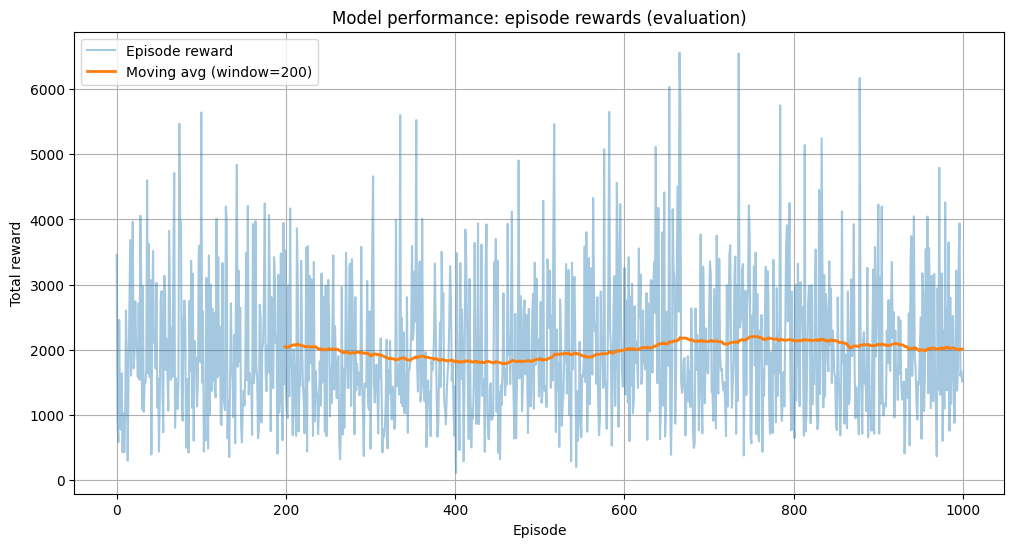


Mean reward over 1000 episodes: 2005.64
Std  reward over 1000 episodes: 1097.25


In [58]:
# =========================================
# 📈 Evaluate model & plot average rewards
# =========================================

import numpy as np
import matplotlib.pyplot as plt

# Number of evaluation episodes
N_EPISODES = 1000  # change if you want

def moving_average(values, window):
    if len(values) < window:
        return np.array(values)
    weights = np.ones(window) / window
    return np.convolve(values, weights, mode="valid")

episode_returns = []

for ep in range(N_EPISODES):
    # Create a fresh env each episode
    env = TwentyFortyEightEnvMasked()
    obs, info = env.reset()
    done = False
    ep_ret = 0.0

    while not done:
        # Get valid action mask from env
        mask = env.get_action_mask()

        # IMPORTANT: pass mask into predict()
        action, _ = model.predict(obs, action_masks=mask, deterministic=True)

        obs, reward, terminated, truncated, info = env.step(int(action))
        done = terminated or truncated
        ep_ret += reward

    episode_returns.append(ep_ret)
    print(f"Episode {ep+1}/{N_EPISODES} - total reward: {ep_ret:.2f}")

episode_returns = np.array(episode_returns)
ma_window = max(5, N_EPISODES // 5)  # e.g. 5 for 25 eps, 10 for 50 eps
smoothed = moving_average(episode_returns, ma_window)

plt.figure(figsize=(12, 6))
plt.plot(episode_returns, label="Episode reward", alpha=0.4)
plt.plot(
    np.arange(len(smoothed)) + (ma_window - 1),
    smoothed,
    label=f"Moving avg (window={ma_window})",
    linewidth=2,
)
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.title("Model performance: episode rewards (evaluation)")
plt.grid(True)
plt.legend()
plt.show()

print(f"\nMean reward over {N_EPISODES} episodes: {episode_returns.mean():.2f}")
print(f"Std  reward over {N_EPISODES} episodes: {episode_returns.std():.2f}")


In [22]:
eval_env = TwentyFortyEightEnvMasked()
eval_env = ActionMasker(eval_env, mask_fn)

obs, info = eval_env.reset()
done = False
step = 0

raw_env = eval_env.env  # underlying TwentyFortyEightEnvMasked

print("Initial Board:")
raw_env.render()

while not done and step < 40:
    mask = raw_env.get_action_mask()
    action, _ = model.predict(obs, deterministic=True)

    old_board = raw_env.board.copy()
    obs, reward, terminated, truncated, info = eval_env.step(int(action))
    done = terminated or truncated
    moved = not np.array_equal(raw_env.board, old_board)

    print(f"\nStep {step} | done={done}")
    print(f"  Mask:  {mask}  (up, down, left, right)")
    print(f"  Action: {int(action)} | Reward: {reward} | Moved? {moved}")
    raw_env.render()

    step += 1


Initial Board:

Score: 0
-------------------------
|     |     |     |     |
-------------------------
|     |     |     |     |
-------------------------
|     |     |  2  |     |
-------------------------
|     |     |  2  |     |
-------------------------

Step 0 | done=False
  Mask:  [ True  True  True  True]  (up, down, left, right)
  Action: 1 | Reward: 4.0 | Moved? True

Score: 4
-------------------------
|     |     |     |     |
-------------------------
|     |     |     |     |
-------------------------
|     |     |     |     |
-------------------------
|     |     |  4  |  2  |
-------------------------

Step 1 | done=False
  Mask:  [ True False  True False]  (up, down, left, right)
  Action: 1 | Reward: -2 | Moved? False

Score: 4
-------------------------
|     |     |     |     |
-------------------------
|     |     |     |     |
-------------------------
|     |     |     |     |
-------------------------
|     |     |  4  |  2  |
-------------------------

Step 2 | d